# Imports

In [177]:
import datetime
import time
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sagemaker

<hr>

In [178]:
wires = range(15)
n_layers = 3
dev = qml.device('default.qubit', wires=wires)

###### dataset structure: `[equity number][train or test][sample number][past or future]`

In [179]:
dataset = np.load('data/dataset.npy', allow_pickle=True)
data = np.load('data/prices_15_4.npy', allow_pickle=True)

In [180]:
dis_dataset = dataset[1]

In [181]:
msft_data = data[0]
msft_b = msft_data[0]
msft_f = msft_data[1]

In [182]:
def flatten(data):
    in_one_arr = []
    for i in range(19):
        if i <= 14:
            in_one_arr.append(data[0][i])
        elif i >=15:
            in_one_arr.append(data[1][i-15])
    return np.reshape(in_one_arr, (1,1,19))

# Structure of QGAN

## Generator

In [183]:
@qml.qnode(dev, interface="tf")
def gen_circuit(b_seq, gen_weights):
    # Embedding past time series onto circuit (bath)
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
        
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(gen_weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [184]:
init_gen_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, (n_layers, len(wires), 3)))

In [185]:
init_gen_weights

<tf.Variable 'Variable:0' shape=(3, 15, 3) dtype=float64, numpy=
array([[[ 1.36261116, -2.79491778, -1.83895745],
        [-2.93394818,  0.04231392,  0.19416223],
        [ 1.79943539,  0.42691041, -0.73783131],
        [-0.74939649, -2.86694191, -1.10190247],
        [-2.47571856,  2.82741802, -0.66860746],
        [ 2.66789976,  2.77520896, -0.74305397],
        [-0.29789047,  1.61608301, -0.69312041],
        [-2.36472992,  0.55359983,  1.10941988],
        [-0.66489347, -0.66233769, -2.1115642 ],
        [-2.0605086 ,  2.60169093, -1.85911558],
        [-1.60142565, -1.52158944, -2.46572492],
        [ 2.81872326,  1.62395138, -2.64152669],
        [ 0.38479026, -1.27336543,  1.13479408],
        [-0.14627147, -2.05976807, -2.00476034],
        [ 0.05698578, -0.94310694,  0.96383709]],

       [[-1.91176152, -1.08404075, -1.14473982],
        [ 0.63192623, -3.05366879, -0.79273765],
        [-1.65385356, -2.70066334,  2.44591124],
        [-0.80376348,  2.48391025,  0.47847137],
  

In [186]:
gen_circuit(dis_dataset[0][1][0], init_gen_weights)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([-0.00031769,  0.006511  ,  0.01390315, -0.00513738])>

## Discriminator

In [187]:
def make_discrim():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, input_shape=[1, 19]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [188]:
discriminator = make_discrim()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1, 16)             320       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1, 16)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 16)             272       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 1, 16)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1, 128)            2176      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)             

In [189]:
discriminator(tf.reshape(tf.concat([msft_data[0], msft_data[1]], 0), (1,1,19)))

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[0.47649205]]], dtype=float32)>

## Loss — real is 1, fake is 0

In [190]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    """Calculating loss"""
    return cross_entropy(np.ones_like(fake_output), fake_output)

In [191]:
def discriminator_loss(fake_output, real_output):    
    """Compute discriminator loss.""" 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [192]:
def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

## Optimizer

In [193]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

## One train step

In [194]:
def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape: 
        generated_prices = tf.concat([equity_data[0], gen_circuit(equity_data[0], gen_weights)], 0)
        generated_prices = tf.reshape(generated_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))

        real_prices = tf.concat([equity_data[0], equity_data[1]], 0)
        real_prices = tf.reshape(real_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))
        
        """Getting outputs from discrim"""
        real_output = discriminator(real_prices)
        fake_output = discriminator(generated_prices)
        
        """Calculating loss"""
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip([gradients_of_generator], [gen_weights]))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], gen_circuit(equity_data[0], gen_weights))
    
    return gen_loss, disc_loss, gen_weights, acc, real_output[0][0][0], fake_output[0][0][0]

## Visualizing the training process

In [196]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/metrics"
file_writer = tf.summary.create_file_writer(logdir)
file_writer.set_as_default()

In [197]:
gloss = []
dloss = []
acc_results = []
epoch_acc_results = []

In [198]:
EPOCHS = 2000
batch_size = 1

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_gen_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_gen_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, dl, w, acc, fake_output, real_output = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)
            dloss.append(dl)

            tf.summary.scalar('Generator Loss', data=gl.numpy(), step=epoch)
            tf.summary.scalar('Discriminator Loss', data=dl.numpy(), step=epoch)
            tf.summary.scalar('Prediction Accuracy', data=acc, step=epoch)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n         Disc loss: {dl} \n             Accuracy: {acc}")
        
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], gen_circuit(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        epoch_acc_results.append(epoch_acc)

    return new_gen_w

In [ ]:
new_gen_w = train(dis_dataset[0], EPOCHS, start_epoch=1, new_gen_w=new_gen_w) 

## Training metrics

In [ ]:
plt.plot(range(len(epoch_acc_results)), epoch_acc_results)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()

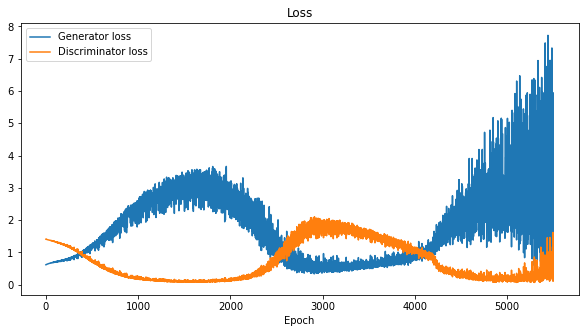

In [148]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Generator loss")
plt.plot(range(len(dloss)), dloss, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Results compared

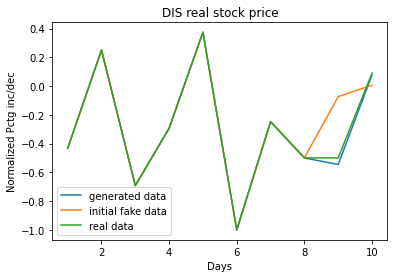

In [144]:
for i in range(batch_size):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(dis_dataset[0][i][0], dis_dataset[0][i][1])
    fake_stats = tf.concat([dis_dataset[0][i][0], gen_circuit(dis_dataset[0][i][0], new_gen_w)], 0).numpy()
    init_fake_stats = tf.concat([dis_dataset[0][i][0], gen_circuit(dis_dataset[0][i][0], init_gen_weights)], 0).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, init_fake_stats, label="initial fake data")
    plt.plot(days, real_stats, label="real data")
    plt.title("DIS real stock price")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg inc/dec")
    plt.legend()
    plt.show()